In [1]:
%run 'psd_mc_functions.ipynb'

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os

Reading XAMS data from pickles...
Read data in 86.62 seconds


In [2]:
def mock_s1_wv_sigma(time_matrix, wv_matrix, **params):
    """Take data S1s, bootstrap sample, then check what the variance is"""
    params = get_params(params)
    bootstrap_trials = params['bootstrap_trials']
    n_s1s = wv_matrix.shape[1]
    waveform_templates = np.zeros((len(spe_ts), bootstrap_trials))

    for i in range(bootstrap_trials):
        new_indices = np.random.randint(n_s1s, size=n_s1s)

        waveform_templates[:, i] = average_pulse(time_matrix[:, new_indices], 
                                                 wv_matrix[:, new_indices], **params)
        
    return np.std(waveform_templates, axis=1)

In [8]:
def build_mock_data(verbose=True, **params):
    '''
    Mock data is simulated data with just the right statistics given the data.
    Arguments: parameters specifying the dataset (dset, e_min, e_max), plus the true values (i.e. the fitted values).
    '''
#     params = get_params(params)
    d = xams_data[params['dset']]
    d = d[(d['e_ces'] >= params['e_min']) & (d['e_ces'] < params['e_max']) ]
    n_s1s = len(d)
    if verbose:
        print("Selected data from %s, energy from %d to %d" % (params['dset'], params['e_min'], params['e_max']))
        print("Selected %d waveforms" % (n_s1s))
    
    # Take a generous sample of photons to eneter into the simulation
    n_photons_guess = int(1.5 * sum(d['cs1']))
    s1_waveforms, s1_waveforms_error, time_matrix, t_shift  = simulate_s1_pulse(n_photons = n_photons_guess, **params)
    # Cut off the excess waveforms to exactly match stats
    if len(t_shift) < n_s1s:
        raise ValueError("Number of S1s incorrect, how is possible?")
    s1_waveforms = s1_waveforms[:, :n_s1s]
    s1_waveforms_error = s1_waveforms_error[:, :n_s1s]
    t_shift = t_shift[:n_s1s]
    time_matrix = time_matrix[:, :n_s1s]
    avg = average_pulse(time_matrix, s1_waveforms)
    stored_stat = mock_s1_wv_sigma(time_matrix, s1_waveforms)
    return avg, stored_stat

In [10]:
def build_grid_around_value(variables, values, step_sizes, nsteps, **params):
    mins = [values[i] - nsteps * step_sizes[i] for i in range(len(variables))]
    maxes= [values[i] + nsteps * step_sizes[i] for i in range(len(variables))]
    dicts = produce_settings_dicts(variables, mins, maxes, step_sizes, **params)
    return dicts

In [15]:
def process_dicts(dicts, avg, stored_stat):
    for p in dicts:
        model, syst_err, spe_err = s1_models_error(**p)
        chi2 = gof_manual(avg, model, syst_err, spe_err, stored_stat_value = stored_stat, verbose=False, **p)
        p['chi2'] = chi2
    return dicts

In [16]:
def check_settings(variables = ['t3', 'fs',  't1', 'tts'], step_sizes = [0.25, 0.005, 0.125, 0.125],
                   nsteps = 2, nphotons_histat = int(2e6), **params):
    avg, stored_stat = build_mock_data(**params)
    values = [params[var] for var in variables]
    dicts = build_grid_around_value(variables, values, step_sizes, nsteps, nphotons=nphotons_histat)
    
    dicts = process_dicts(dicts, avg, stored_stat)
    return dicts

In [13]:
dicts = check_settings(nsteps = 2, nphotons_histat=int(5e4), dset = 'er', e_min = 2, e_max = 5, 
               fs = 0.235, t1 = 0.5, t3 = 22.25, tts = 2.125)

Selected data from er, energy from 2 to 5
Selected 741 waveforms
Loaded 1 settings.
gof=1.5409374792685488, fs=0.235, t1=0.5, t3=22.25, tts=2.125


In [104]:
nsteps = 2
variables = ['t3', 'fs',  't1', 'tts']
values = [22.25, 0.235, 0.5, 2.125]
step_sizes = [0.25, 0.005, 0.125, 0.125]
# step_sizes = [0.5 * parval for parval in [0.5,  0.01,  0.25,  0.25]] # WARNING WARNING set to low value

In [106]:
dicts = build_grid_around_value(variables, values, step_sizes, nsteps, n_photons = int(5e5))

Loaded 625 settings.


In [109]:
df = pd.DataFrame(list(dicts))

In [2]:
p_all = dict(
    dset = 'er',
    e_min = 2,
    e_max = 5
)

In [22]:
p_true = {
 'fs': 0.23499999999999999,
 't1': 0.5,
 't3': 22.25,
 'tts': 2.125}

p_true = merge_two_dicts(p_all, p_true)

In [4]:
d = xams_data[p_all['dset']]
d = d[(d['e_ces'] >= p_all['e_min']) & (d['e_ces'] < p_all['e_max']) ]

In [18]:
# This is how many S1s we simulate
n_s1s = len(d)

In [6]:
n_photons_guess = int(1.5 * sum(d['cs1']))

In [7]:
n_photons_guess

15015

In [33]:
s1_waveforms, s1_waveforms_error, time_matrix, t_shift  = simulate_s1_pulse(n_photons = n_photons_guess, **p_all)
s1_waveforms = s1_waveforms[:, :n_s1s]
s1_waveforms_error = s1_waveforms_error[:, :n_s1s]
t_shift = t_shift[:n_s1s]
time_matrix = time_matrix[:, :n_s1s]

In [34]:
time_matrix

array([[-100.3497289 , -103.35235468, -102.45217145, ..., -101.50794111,
        -118.80646788, -103.95952436],
       [ -98.3497289 , -101.35235468, -100.45217145, ...,  -99.50794111,
        -116.80646788, -101.95952436],
       [ -96.3497289 ,  -99.35235468,  -98.45217145, ...,  -97.50794111,
        -114.80646788,  -99.95952436],
       ..., 
       [ 283.6502711 ,  280.64764532,  281.54782855, ...,  282.49205889,
         265.19353212,  280.04047564],
       [ 285.6502711 ,  282.64764532,  283.54782855, ...,  284.49205889,
         267.19353212,  282.04047564],
       [ 287.6502711 ,  284.64764532,  285.54782855, ...,  286.49205889,
         269.19353212,  284.04047564]])

In [36]:
avg = average_pulse(time_matrix, s1_waveforms)

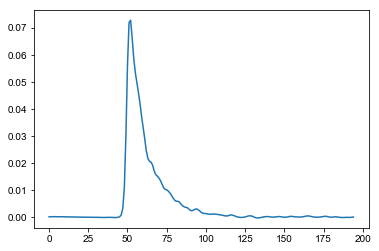

In [37]:
plt.plot(avg)

In [40]:
stored_stat = fake_real_s1_wv_sigma(time_matrix, s1_waveforms)

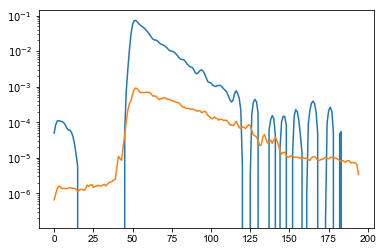

In [46]:
plt.plot(avg)
plt.fill_between(avg - stored_stat, avg + stored_stat)
plt.plot(stored_stat)
plt.yscale('log')

In [31]:
# This is our model, now how well can we fit it?

In [47]:
p = merge_two_dicts(p_all, p_true)

In [48]:
p['n_photons'] = int(5e5)

In [52]:
for i in range(5):
    model, syst_err, spe_err = s1_models_error(**p)
    chi2 = gof_manual(avg, model, syst_err, spe_err, stored_stat_value = stored_stat, **p)

gof=1.1943060360636026, fs=0.235, t1=0.5, t3=22.25, tts=2.125
gof=1.1632981470520567, fs=0.235, t1=0.5, t3=22.25, tts=2.125
gof=1.1442923436435235, fs=0.235, t1=0.5, t3=22.25, tts=2.125
gof=1.1560519896698302, fs=0.235, t1=0.5, t3=22.25, tts=2.125
gof=1.278532437748584, fs=0.235, t1=0.5, t3=22.25, tts=2.125


In [92]:
n_steps = 2
variables = ['t3', 'fs',  't1', 'tts']
step_sizes = [0.5 * parval for parval in [0.5,  0.01,  0.25,  0.25]] # WARNING WARNING set to low value
mins = [p_true[variables[i]] - n_steps * step_sizes[i] for i in range(len(variables))]
maxes= [p_true[variables[i]] + n_steps * step_sizes[i] for i in range(len(variables))]
dicts = produce_settings_dicts(variables, mins, maxes, step_sizes, n_photons = int(5e5))

Loaded 625 settings.


In [98]:
for i, p in enumerate(dicts):
    model, syst_err, spe_err = s1_models_error(**p)
    chi2 = gof_manual(avg, model, syst_err, spe_err, stored_stat_value = stored_stat, **p)
    p['chi2'] = chi2

gof=2.8206021905470453, fs=0.22499999999999998, t1=0.25, t3=21.75, tts=1.875
gof=2.6087681091741626, fs=0.22499999999999998, t1=0.25, t3=21.75, tts=2.0
gof=2.4510303674463647, fs=0.22499999999999998, t1=0.25, t3=21.75, tts=2.125
gof=2.45478923955988, fs=0.22499999999999998, t1=0.25, t3=21.75, tts=2.25
gof=2.7869780319196584, fs=0.22499999999999998, t1=0.25, t3=21.75, tts=2.375
gof=2.7874912518326296, fs=0.22499999999999998, t1=0.375, t3=21.75, tts=1.875
gof=2.49836897440707, fs=0.22499999999999998, t1=0.375, t3=21.75, tts=2.0
gof=2.1471355708797777, fs=0.22499999999999998, t1=0.375, t3=21.75, tts=2.125
gof=2.434740127399608, fs=0.22499999999999998, t1=0.375, t3=21.75, tts=2.25
gof=2.6808611195211536, fs=0.22499999999999998, t1=0.375, t3=21.75, tts=2.375
gof=2.6965756926713094, fs=0.22499999999999998, t1=0.5, t3=21.75, tts=1.875
gof=2.315527601427055, fs=0.22499999999999998, t1=0.5, t3=21.75, tts=2.0
gof=2.3280858323692692, fs=0.22499999999999998, t1=0.5, t3=21.75, tts=2.125
gof=2.26877

In [99]:
import pandas as pd
df = pd.DataFrame(list(dicts))
df.iloc[df['chi2'].idxmin()]

chi2              1.093516
fs                0.245000
n_photons    500000.000000
t1                0.500000
t3               22.750000
tts               2.250000
Name: 613, dtype: float64

In [95]:
import pandas as pd
df = pd.DataFrame(list(dicts))
df.iloc[df['chi2'].idxmin()]

chi2              1.020818
fs                0.245000
n_photons    500000.000000
t1                0.750000
t3               22.750000
tts               2.375000
Name: 624, dtype: float64

In [97]:
mins

[21.75, 0.22499999999999998, 0.25, 1.875]

chi2              1.273619
fs                0.240000
n_photons    500000.000000
t1                0.625000
t3               22.500000
tts               2.250000
Name: 80, dtype: float64

In [91]:
p_true

{'dset': 'er',
 'e_max': 5,
 'e_min': 2,
 'fs': 0.235,
 't1': 0.5,
 't3': 22.25,
 'tts': 2.125}

In [84]:
df

,chi2,fs,n_photons,t1,t3,tts
0,2.058910,0.230,500000,0.375,22.00,2.000
1,2.027801,0.230,500000,0.375,22.00,2.125
2,2.023981,0.230,500000,0.375,22.00,2.250
3,2.130555,0.230,500000,0.500,22.00,2.000
4,1.973730,0.230,500000,0.500,22.00,2.125
5,2.060170,0.230,500000,0.500,22.00,2.250
6,2.244192,0.230,500000,0.625,22.00,2.000
7,1.881243,0.230,500000,0.625,22.00,2.125
8,1.796069,0.230,500000,0.625,22.00,2.250
9,1.882942,0.230,500000,0.375,22.25,2.000


In [58]:
maxes

[23.25, 0.255, 1.5, 2.625]

In [ ]:
produce_settings_dict([''])

In [ ]:
 'fs': 0.23499999999999999,
 't1': 0.5,
 't3': 22.25,
 'tts': 2.125}

In [ ]:
#x = produce_settings_dicts(['t3', 'fs',  't1', 'tts'], 
#                           [23,   0.15,  0.5,  0.5], 
#                           [27,   0.21,  4.5,  2.5],
#                           [0.5,  0.01,  0.5,  0.25],  
#                           200, **p)



In [ ]:
n_spread = 2

In [ ]:
step_size = []

In [ ]:
lower_bound = 

In [ ]:
grid = produce_settings_dicts(['t3', 'fs',  't1', 'tts'], lower_bound, upper_bound, step_size, job_size, **p)

In [38]:
# for p in dicts:
model, syst_err, spe_err = s1_models_error(**p)
chi2 = gof_manual(avg, model, syst_err, spe_err, **p)

KeyboardInterrupt: 

In [37]:
chi2

0.084575957447099004

In [ ]:
gof_manual(ydata = avg, model, syst_err, spe_err, verbose=True):

In [ ]:
 'fs': 0.23499999999999999,
 't1': 0.5,
 't3': 22.25,
 'tts': 2.125